In [1]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html

In [5]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import string
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
def findFiles(path): return glob.glob(path)

<h2>Choose dataset

In [6]:
#all datapoints
pathTo = 'dataset-all/rnn/'

#just repfinder's jars
# pathTo = 'dataset-all/rnn/training/'

print(findFiles(pathTo + 'training/*.txt'))
print(findFiles(pathTo + 'validation/*.txt'))

['dataset-all/rnn/training\\yes.txt', 'dataset-all/rnn/training\\no.txt']
['dataset-all/rnn/validation\\yes.txt', 'dataset-all/rnn/validation\\no.txt']


In [7]:
all_letters = string.ascii_letters + " .,;'"
# n_letters = 200
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in all_letters
#     )
    return s

# print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
category_lines_val = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles(pathTo + 'training/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

for filename in findFiles(pathTo + 'validation/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    # all_categories.append(category)
    lines = readLines(filename)
    category_lines_val[category] = lines

n_categories = len(all_categories)
print(len(all_letters))
print(all_categories)
print([len(l) for l in category_lines['yes'][:5]])

57
['yes', 'no']
[76, 89, 44, 92, 101]


In [8]:
# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [9]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

# print(categoryFromOutput(output))

In [10]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomValidationExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_val[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = no / line = web.cors.reactive.CorsUtils.isSameOrigin(ServerHttpRequest)web.cors.reactive.PreFlightRequestWebFilter()
category = no / line = lucene.index.IndexWriter.getCommitData()lucene.index.IndexWriter.getFieldNames()
category = no / line = Matchers.anyMap()ArgumentMatchers.anyMapOf()
category = no / line = cassandra.dht.BytesToken.getTokenValue()cassandra.index.sasi.Term.getTerm()
category = no / line = action.get.GetResponse.exists()action.get.GetRequest.refresh()
category = yes / line = action.index.IndexResponse.version()action.index.IndexResponse.getVersion()
category = no / line = action.admin.indices.exists.indices.IndicesExistsResponse.exists()action.admin.indices.exists.indices.IndicesExistsResponse.readFrom()
category = yes / line = Matchers.eq(int)ArgumentMatchers.eq(int)
category = yes / line = Matchers.matches(String)ArgumentMatchers.matches(String)
category = no / line = search.facet.FacetProcessors.processor(String)search.facet.FacetParseElement.parse()


In [11]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

# n_hidden = 128


In [12]:
n_hidden = n_letters
rnn = RNN(n_letters, n_hidden, n_categories)
criterion = nn.NLLLoss()

In [13]:
def train(category_tensor, line_tensor, learning_rate):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

In [14]:
import time
import math

n_iters = 25000
print_every = 500
plot_every = 200

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

rate = 0.002

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # if iter < n_iters/10:
    #     rate = 0.005
    # elif iter > 5 * n_iters / 10:
    #     rate = 0.001
    # else:
    #     rate = 0.002
    output, loss = train(category_tensor, line_tensor, rate)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.7f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 2% (0m 5s) 0.7217581 DBMaker.newMemoryDirectDB()DBMaker.memoryDirectDB() / no ✗ (yes)
1000 4% (0m 10s) 0.6432169 action.mlt.MoreLikeThisRequestBuilder.setMinDocFreq(int)index.query.MoreLikeThisQueryBuilder.minDocFreq(int) / yes ✓
1500 6% (0m 15s) 0.6667250 core.MethodParameter.increaseNestingLevel()core.MethodParameter.nested() / no ✓
2000 8% (0m 21s) 0.7987275 dockerjava.api.model.HostConfig.isPrivileged()dockerjava.api.model.HostConfig.getPrivileged() / no ✗ (yes)
2500 10% (0m 26s) 0.6844273 action.index.IndexResponse.version()action.index.IndexResponse.getVersion() / yes ✓
3000 12% (0m 32s) 0.6142471 index.query.GeoDistanceFilterBuilder.lon(double)index.query.GeoDistanceQueryBuilder.coerce() / no ✓
3500 14% (0m 38s) 0.5404952 sshd.common.util.Buffer.getString()sshd.common.util.buffer.Buffer.toString() / no ✓
4000 16% (0m 43s) 0.4521051 index.query.RangeFilterBuilder.gt(Object)index.query.RangeQueryBuilder.lt() / no ✓
4500 18% (0m 49s) 0.2640603 tomakehurst.wiremock.client.Mappin

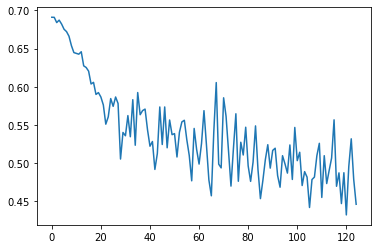

In [15]:
plt.figure()
plt.plot(all_losses)

In [16]:
n_confusion = 500

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
precision = {
    'yes': {
        'tp': 0,
        'total': 0
    },
    'no': {
        'tp': 0,
        'total': 0
    }
}

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomValidationExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    # correct = '✓' if guess == category else '✗ (%s)' % category
    # print(line, guess, correct)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    precision[category]['total'] += 1
    if category is guess:
        precision[category]['tp'] += 1

print(precision)
print(confusion)

yp = precision['yes']['tp']/precision['yes']['total']
yr = float(confusion[0][0]/sum(confusion[0]))
print('(Yes) Precision:', yp)
# print('No precision:', precision['no']['tp']/precision['no']['total'])
print('(Yes) Recall:', yr)
print('(Yes) F1:', 2 * (yp * yr) / (yp + yr))

np = precision['no']['tp']/precision['no']['total']
nr = float(confusion[1][1]/sum(confusion[1]))
print('(No) Precision:', np)
# print('No precision:', precision['no']['tp']/precision['no']['total'])
print('(No) Recall:', nr)
print('(No) F1:', 2 * (np * nr) / (np + nr))

{'yes': {'tp': 189, 'total': 253}, 'no': {'tp': 201, 'total': 247}}
tensor([[189.,  64.],
        [ 46., 201.]])
(Yes) Precision: 0.7470355731225297
(Yes) Recall: 0.747035562992096
(Yes) F1: 0.7470355680573127
(No) Precision: 0.8137651821862348
(No) Recall: 0.8137651681900024
(No) F1: 0.8137651751881186


C:\Users\mgwei\AppData\Local\Temp/ipykernel_1700/2806226085.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\mgwei\AppData\Local\Temp/ipykernel_1700/2806226085.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


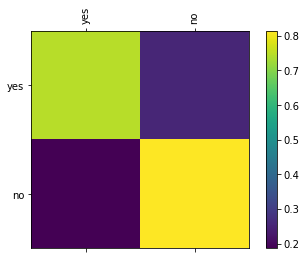

In [17]:
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()